Slightly modified by jw purely for meetup walkthough sessions. any errors would be mine as the original code worked just fine.
Highly recommend the book associated with this - available at manning.com Deep Reinforcement Learning in Action by Zai and Brown. Sept 2019.

# Deep Reinforcement Learning <em> in Action  </em>
## Ch 3 - Deep Q-Learning

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import torch
from torch.autograd import Variable
from Gridworld import *
from IPython.display import clear_output
import random
from matplotlib import pylab as plt
print('-go-')

-go-


#### Helper functions

In [2]:
def running_mean(x, N=500):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

### Test model

In [3]:
def testModel(model, mode='static', display=True):
    epsilon = 0.05
    max_moves = 50
    win = False
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = Variable(torch.from_numpy(state_).float())
    if display: 
        print("Initial State:")
        print(test_game.display())
    status = 1
    #while game still in progress
    while(status == 1):
        qval = model(state)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        #action_ = np.argmax(qval_) #take action with highest Q-value
        action = action_set[action_]
        if display: print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = Variable(torch.from_numpy(state_).float())
        if display: print(test_game.display())
        reward = test_game.reward()
        if reward == 10:
            status = 0
            win = True
            if display: print("You won! Reward: {}".format(reward,))
        elif reward == -10:
            status = 0
            if display: print("Game lost; stepped into the pit. Penalty: {}".format(reward,))
        i += 1 #If we're taking more than 10 actions, just stop, we probably can't win this game
        if (i > max_moves):
            if display: print("Game lost; too many moves.")
            break
    return win

In [4]:
def test_win_perc(model, max_games=1000):
    wins = 0
    for i in range(max_games):
        win = testModel(model, 'random', display=False)
        if win:
            wins += 1
    win_perc = float(wins) / float(max_games)
    print("Games played: {0}, # of wins: {1}".format(max_games,wins))
    print("Win percentage: {}".format(win_perc))

# Deep Q-Learning

In [5]:
l1 = 64
l2 = 164
l3 = 150
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)

loss_fn = torch.nn.MSELoss(size_average=False)

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


#reinforcement learning specific parameters
gamma = 0.9 #since it may take several moves to goal, making gamma high
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

C:\anaconda3\envs\myml\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


##### Without experience replay

In [62]:
epochs = 1 #normally 1000 use 1 to dump values and observe change - uncomment the clear_output call below for more epochs
losses = []
for i in range(epochs):
    game = Gridworld(size=4, mode='random') #'static' means u win quickly, random not so
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = Variable(torch.from_numpy(state_).float())
    status = 1
    #while game still in progress
    while(status == 1):
        qval = model(state)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = (np.argmax(qval_))
        
        action = action_set[action_]
        game.makeMove(action)
        new_state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        new_state = Variable(torch.from_numpy(new_state_).float())
        reward = game.reward()
        newQ = model(new_state.reshape(1,64)).data.numpy()
        maxQ = np.max(newQ)
        y = np.zeros((1,4))
        y[:] = qval_[:]
        if reward == -1:
            update = (reward + (gamma * maxQ))
        else:
            update = reward
        y[0][action_] = update
        y = Variable(torch.from_numpy(y).float())
        loss = loss_fn(qval, y)
        print('noreplay iteration loss ',i, '::',loss.item())
        optimizer.zero_grad()
        loss.backward()
        #losses.append(loss.data[0]) jw torch 1.1 update
        losses.append(loss.item())
        optimizer.step()
        state = new_state
        if reward != -1:
            status = 0
            print('game done at update=',update,' qval ',qval,' qval_ ',qval_)
            print('\t newQ ',newQ, ' maxQ ',maxQ, ' y[0][action_] is ',y[0][action_])
            print('last y ',y , '\t action', action)
        #clear_output(wait=True)       please make sure to uncomment this for larger epoch counts!!
    if epsilon > 0.1:
        epsilon -= (1/epochs)

noreplay iteration loss  0 :: 5.74303674697876
game done at update= -10  qval  tensor([[-8.7876, -7.9908, -7.6035, -8.9187]], grad_fn=<AddmmBackward>)  qval_  [[-8.78759   -7.99078   -7.6035366 -8.918736 ]]
	 newQ  [[-8.541402  -7.4437757 -6.8389235 -8.423344 ]]  maxQ  -6.8389235  y[0][action_] is  tensor(-10.)
last y  tensor([[ -8.7876,  -7.9908, -10.0000,  -8.9187]]) 	 action l


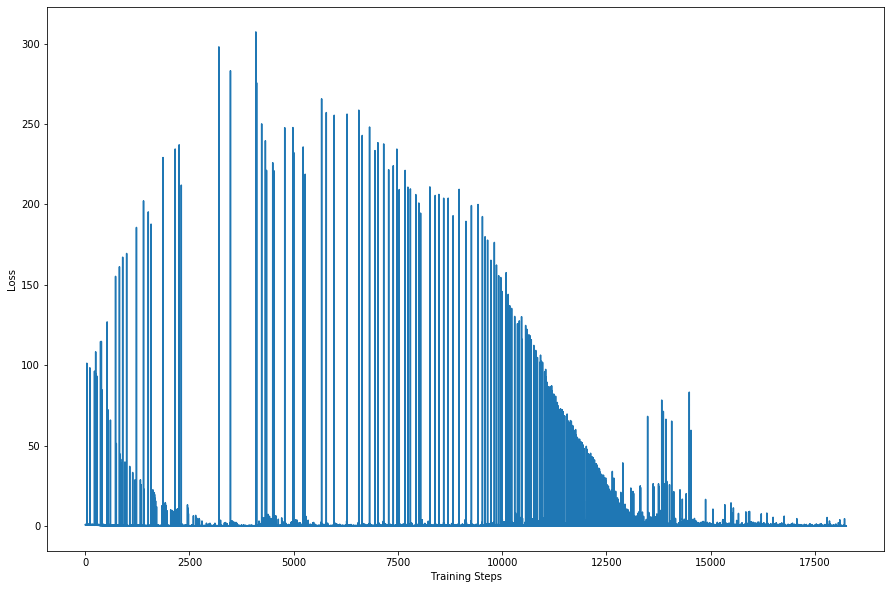

In [7]:
plt.figure(figsize=(15,10))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.plot(losses)
plt.savefig("dqn_1_loss_plot.pdf", format="pdf")

In [8]:
testModel(model, 'random')

Initial State:
[[' ' ' ' '-' ' ']
 [' ' ' ' ' ' '+']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 0; Taking action: u
[[' ' ' ' '-' ' ']
 ['P' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 1; Taking action: u
[['P' ' ' '-' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 2; Taking action: l
[['P' ' ' '-' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 3; Taking action: l
[['P' ' ' '-' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 4; Taking action: l
[['P' ' ' '-' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 5; Taking action: l
[['P' ' ' '-' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 6; Taking action: u
[['P' ' ' '-' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 7; Taking action: l
[['P' ' ' '-' ' ']
 [' ' ' ' ' ' '+']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' 'W']]
Move #: 8; Taking action: l
[['P' ' ' '-' ' ']
 [' ' ' ' ' ' '+']
 [

False

In [9]:
l1 = 64
l2 = 200
l3 = 250 #was 150
l4 = 100
l5 = 4

model2 = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4),
    torch.nn.ReLU(),
    torch.nn.Linear(l4,l5)
)

loss_fn2 = torch.nn.MSELoss(size_average=False)
#
#from the docs:
#By default, the losses are averaged over each loss element in the batch. Note that for some losses, 
#there are multiple elements per sample. 
#If the field size_average is set to False, the losses are instead summed for each minibatch.


learning_rate2 = 1e-4  #was 1e-4 jw 8/30
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate2)


#reinforcement learning specific parameters
gamma = 0.9 #since it may take several moves to goal, making gamma high
epsilon = 0.9   #was 1.0 - set to 0.2 for testing on 8/28

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

C:\anaconda3\envs\myml\lib\site-packages\torch\nn\_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


### With experience replay

In [27]:
epochs = 2000 #1500 original
losses = []
batchSize = 40
buffer = 80
replay = []
max_moves = 75
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = Variable(torch.from_numpy(state_).float())
    status = 1
    mov = 0
    #while game still in progress
    while(status == 1):
        mov += 1
        qval = model2(state)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = (np.argmax(qval_))
        
        action = action_set[action_]
        game.makeMove(action)
        new_state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        new_state = Variable(torch.from_numpy(new_state_).float())
        reward = game.reward()
        
        if (len(replay) < buffer): #if buffer not filled, add to it
            replay.append((state, action_, reward, new_state))
        else: #if buffer full, overwrite old values
            replay.pop(0)
            replay.append((state, action_, reward, new_state))
            #randomly sample our experience replay memory
            minibatch = random.sample(replay, batchSize)
            X_train = Variable(torch.empty(batchSize, 4, dtype=torch.float)) #hodls old qvals
            y_train = Variable(torch.empty(batchSize, 4, dtype=torch.float)) #holds optimal pred qvals
            h = 0
            for memory in minibatch:
                old_state, action_m, reward_m, new_state_m = memory
                #old_state = Variable(torch.from_numpy(old_state_).float())
                #new_state = Variable(torch.from_numpy(new_state_).float())
                old_qval = model2(old_state)
                #action = action_set[action_]
                newQ = model2(new_state_m).data.numpy()
                maxQ = np.max(newQ)
                y = torch.zeros((1,4))
                y[:] = old_qval[:]
                if reward == -1:
                    update = (reward_m + (gamma * maxQ))
                else:
                    update = reward_m
                y[0][action_m] = update
                X_train[h] = old_qval
                y_train[h] = Variable(y)
                h+=1
                
            
            #X_train = Variable(torch.from_numpy(np.asarray(X_train)).float())
            #y_train = Variable(torch.from_numpy(np.asarray(y_train)).float())
            
            loss = loss_fn2(X_train, y_train)
            print('iteration ',i, loss.item())
            optimizer2.zero_grad()
            loss.backward()
            losses.append(loss.item())#jw 7/23
            optimizer2.step()
            
            state = new_state
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        clear_output(wait=True)
    if epsilon > 0.1:
        epsilon -= (1/epochs)

iteration  1999 1103.6614990234375


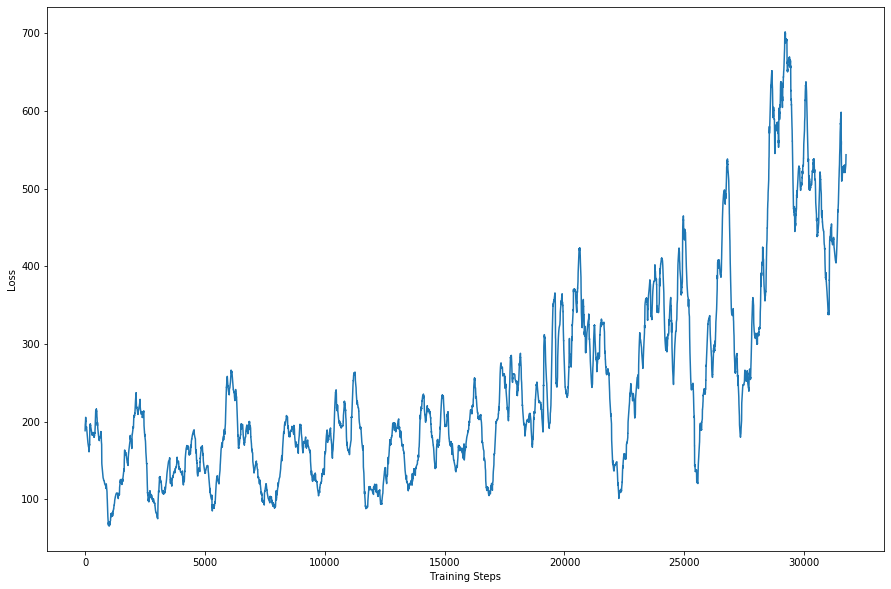

In [28]:
plt.figure(figsize=(15,10))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.plot(running_mean(losses))
#plt.savefig("dqn_3_loss_plot.pdf", format="pdf")

In [29]:
testModel(model2, 'random') #random or player

Initial State:
[[' ' ' ' ' ' 'P']
 ['+' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 [' ' 'W' ' ' ' ']]
Move #: 0; Taking action: l
[[' ' ' ' 'P' ' ']
 ['+' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 [' ' 'W' ' ' ' ']]
Move #: 1; Taking action: l
[[' ' 'P' ' ' ' ']
 ['+' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 [' ' 'W' ' ' ' ']]
Move #: 2; Taking action: l
[['P' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 [' ' 'W' ' ' ' ']]
Move #: 3; Taking action: u
[['P' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 [' ' 'W' ' ' ' ']]
Move #: 4; Taking action: d
[[' ' ' ' ' ' ' ']
 ['+' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 [' ' 'W' ' ' ' ']]
You won! Reward: 10


True

### Test percentage game wins

In [35]:
max_games = 1000
wins = 0
for i in range(max_games):
    #win = testModel('random', display=False) 7/23 looks like a typo jw
    win = testModel(model2,'random',display=False) #random or player
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("model2(replay) Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}".format(win_perc))

model2(replay) Games played: 1000, # of wins: 837
Win percentage: 0.837


### With experience replay and target network

In [31]:
import copy

l1 = 64
l2 = 164
l3 = 250 #was 150
l4 = 4

model3 = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4),
)

model3_ = copy.deepcopy(model3) #Target network

loss_fn3 = torch.nn.MSELoss(size_average=False)

learning_rate3 = 1e-3
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate3)


#reinforcement learning specific parameters
gamma = 0.9 #since it may take several moves to goal, making gamma high
epsilon = 1.0

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)

cpu


In [33]:
model3.to(device)
model3_.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=164, bias=True)
  (1): ReLU()
  (2): Linear(in_features=164, out_features=250, bias=True)
  (3): ReLU()
  (4): Linear(in_features=250, out_features=4, bias=True)
)

In [34]:
#jw remove cuda() calls 
epochs = 1500 #was 700 jw
losses = []
batchSize = 250
buffer = 2000
replay = []
max_moves = 9
c = 500 #target network update step size
c_step = 0
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state = Variable(torch.from_numpy(state_).float()) #.cuda()
    status = 1
    mov = 0
    #while game still in progress
    while(status == 1):
        
        c_step += 1
        if c_step > c:
            model3_.load_state_dict(model3.state_dict())
            c_step = 0
        mov += 1
        
        qval = model3(state)
        qval_ = qval.cpu().data.numpy()
        #values, indices = torch.max(tensor, 0)
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
            #action_ = torch.argmax(qval_)
        action = action_set[action_]
        game.makeMove(action)
        new_state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        new_state = Variable(torch.from_numpy(new_state_).float()) #.cuda()
        reward = game.reward()
        if mov > max_moves:
            reward = -5
        if (len(replay) < buffer): #if buffer not filled, add to it
            replay.append((state, action_, reward, new_state))
        else: #if buffer full, overwrite old values
            replay.pop(0)
            replay.append((state, action_, reward, new_state))
            #randomly sample our experience replay memory
            minibatch = random.sample(replay, batchSize)
            X_train = Variable(torch.empty(batchSize, 4, dtype=torch.float))#.cuda()
            y_train = Variable(torch.empty(batchSize, 4, dtype=torch.float))#.cuda()
            h = 0
            for memory in minibatch:
                old_state, action_m, reward_m, new_state_m = memory
                old_qval = model3(old_state) #TARGET NETWORK!
                #newQ = model3_(new_state_m).cpu().data.numpy()
                newQ = model3_(new_state_m)
                #maxQ = np.max(newQ)
                maxQ = torch.max(newQ)
                y = torch.zeros((1,4))
                y[:] = old_qval[:]
                if reward == -1:
                    update = (reward_m + (gamma * maxQ))
                else:
                    update = reward_m
                y[0][action_m] = update
                X_train[h] = old_qval
                y_train[h] = Variable(y)
                h+=1
            
            loss = loss_fn3(X_train, y_train)
            print(i, loss.item())
            optimizer3.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer3.step()
            
            state = new_state

        if reward != -1:
            status = 0
            mov = 0
        clear_output(wait=True)
    if epsilon > 0.1:
        epsilon -= (1/epochs)

1499 9203.0771484375


In [25]:
testModel(model3.to('cpu'), 'random')

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' '+' '-' 'W']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' '+' '-' 'W']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' '+' '-' 'W']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' '+' '-' 'W']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' '+' '-' 'W']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' '+' '-' 'W']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[[' ' ' ' ' ' ' ']
 ['P' '+' '-' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: r
[[' ' ' ' ' ' ' ']
 [' ' '+' '-' 'W']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
You won! Reward: 10


True

In [26]:
test_win_perc(model3)

Games played: 1000, # of wins: 738
Win percentage: 0.738


2916


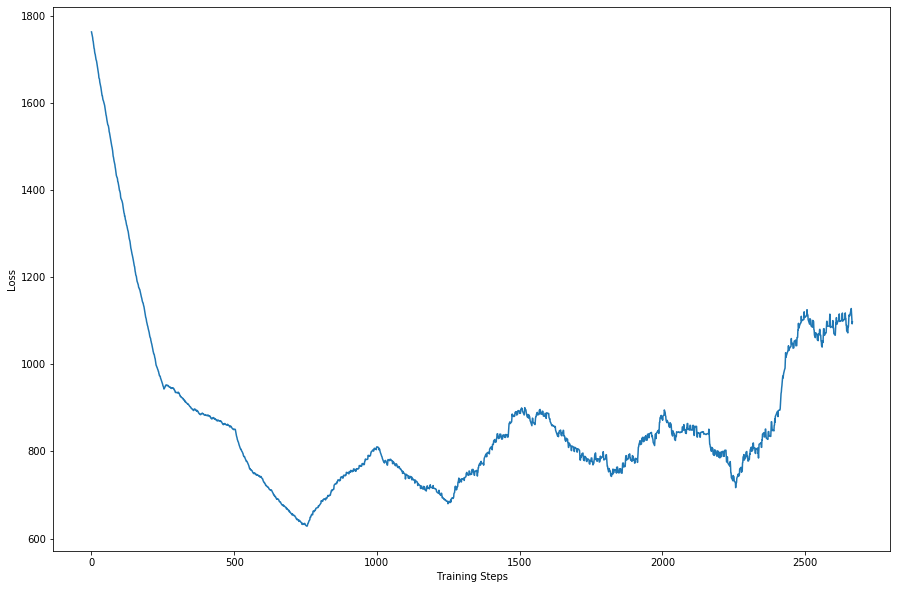

In [20]:
plt.figure(figsize=(15,10))
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.plot(running_mean(losses,250))
print(len(losses))
#plt.savefig("dqn_3_loss_plot.pdf", format="pdf")